# PHYS305 project: Solving the Schrodinger equation in 1D

Project objectives:
- Find the energy eigenvalues and wavefunctions for different quantum potentials using numerical methods.
    - Compare with analytical solutions.
- Simulate the time evolution of wave packet and study its dispersion
- Study the scattering of a wavepacket from a potential barrier, and study transmission and reflection.
- Study resonant tunelling in a double barrier.

The code and examples below are a starting point for further exploration.

*For enquiries, e-mail **Prof. Costas Andreopoulos** <c.andreopoulos @ cern.ch>*

## Solving the time-independent Schrodinger equation

We seek to find the stationary states of a particle inside a potential well. For this, we need to solve the time-independent Schrodinger equation (TISE). In one dimension, the TISE is

$\displaystyle -\frac{\hbar^2}{2m} \frac{d^2\psi(x)}{dx^2} + V(x)\psi(x) = E \psi(x)$.
  
To solve it numerically, we have to ***discretize*** the equation

$\displaystyle \frac{d^2\psi(x)}{dx^2} = 
\frac{d}{dx} \Big( \frac{d\psi(x)}{dx} \Big) \approx 
\frac{\displaystyle \frac{\psi_{i+1}-\psi_{i}}{\Delta x}-\frac{\psi_{i}-\psi_{i-1}}{\Delta x}}{\Delta x} =
\frac{\psi_{i+1} - 2\psi_{i} + \psi_{i-1}}{(\Delta x)^2}$

where $\psi_i = \psi(x_i)$.

Substituting the abobe into the Schrodinger equation, we have

$\displaystyle -\frac{\hbar^2}{2m} \frac{\psi_{i+1} - 2\psi_{i} + \psi_{i-1}}{(\Delta x)^2} + V_i \psi_{i} = E \psi_{i} \Rightarrow$
$\displaystyle 
-\alpha \psi_{i+1} + \Big(V_i + 2 \alpha \Big) \psi_{i} - \alpha \psi_{i-1} = E \psi_{i}$

where $V_i = V(x_i)$ and $\displaystyle \alpha = \frac{\hbar^2}{2m} \frac{1}{(\Delta x)^2}$.

The problem is reduced to finding the eigenvalues and eigenvector of

$\hat{\cal H} {\bf \Psi} = E {\bf \Psi}$

where 

${\bf \Psi} = 
\begin{pmatrix}
\psi_0 \\
\psi_1 \\
...    \\
\psi_{N-1} \\
\end{pmatrix}$
and
$\hat{\cal H} = 
\begin{pmatrix}
V_0 + 2\alpha  & -\alpha       &               & &         &                   & \\
-\alpha        & V_1 + 2\alpha & -\alpha       & &         &                   & \\
               & -\alpha       & V_2 + 2\alpha & &         &                   & \\
               &               &               & &         &                   & \\
               &               &               & &         & -\alpha           & \\
               &               &               & & -\alpha & V_{N-1} + 2\alpha & \\
\end{pmatrix}$

is a tridiagonal matrix whose only non-zero elements are shown above.

## Solving the time-dependent Schrodinger equation

The time dependent Schrodinger equation (TDSE) in one spatial dimension is

$\displaystyle 
\hat{\cal H} \psi(x,t) = i \hbar \frac{\partial \psi(x,t)}{\partial t} \Rightarrow
\frac{\partial \psi(x,t)}{\partial t} = -\frac{i}{\hbar} \displaystyle \hat{\cal H} \psi(x,t)$.

Using the method of Crank and Nicholson, TDSE is approximated as

$\displaystyle 
\frac{\psi(x,t+\Delta t)-\psi(x,t)}{\Delta t} = -\frac{i}{\hbar} \displaystyle \hat{\cal H} \frac{\psi(x,t+\Delta t)+\psi(x,t)}{2}$.

The averaging of $\displaystyle \hat{\cal H} \psi(x,t)$ and $\displaystyle \hat{\cal H} \psi(x,t+\Delta t)$ leads to a symmetrized time evolution, demanded by the time reversibility of the Schrodinger equation. It helps ensure numerical stability and the conservation of probability.

The above equation can be rewritten as

$\displaystyle 
\Big(\cal{I} + b \hat{\cal H} \Big) \psi(x,t+\Delta t) = 
\Big(\cal{I} - b \hat{\cal H} \Big) \psi(x,t)$.

where $\displaystyle b = {\Delta t} \frac{i}{2\hbar}$ and $\cal{I}$ is the identity matrix.

Discretizing $\psi$, we obtain

$\displaystyle 
\hat{\cal A} \psi_{i+1} = \hat{\cal B} \psi_{i}$

where 

$\displaystyle \hat{\cal A} = \cal{I} + b \hat{\cal H}$,
$\displaystyle \hat{\cal B} = \cal{I} - b \hat{\cal H}$,
$\psi_{i} = \psi(x,t_{i})$, and
$\psi_{i+1} = \psi(x,t_{i}+\Delta t)=\psi(x,t_{i+1})$.

Therefore, if we increment time by $dt$, the evolved wavefunction $\psi_{i+1}$ can be computed from $\psi_i$ from

$\displaystyle 
\psi_{i+1} = \hat{\cal A}^{-1} \hat{\cal B} \psi_{i}$


In [3]:
import numpy as np

from scipy.linalg import eigh
from scipy.linalg import solve

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [4]:
def hamiltonian_matrix(V, alpha):
    """ 
    Construct the Hamiltonian matrix (see above)
    Input:    
    - V: Potential as an array with shape (N,) computed for N uniformly distributed values of x.
    - alpha: Value of hbar**2 / (2*m * dx**2), where dx gives the spacing of points in x.
    Output:    
    - H: Hamiltonian matrix, represnted as a numpy array with shape (N,N)
    """
    N = V.shape[0]
    H = np.zeros((N, N))
    # filling diagonal
    np.fill_diagonal(H, V+2*alpha)
    # slicing returns submatrix w/o last  row and first column, so filling upper diagonal
    np.fill_diagonal(H[:-1,1:], -alpha) 
    # slicing returns submatrix w/o first row and last  column, so filling lower diagonal
    np.fill_diagonal(H[1:,:-1], -alpha) 
    
    return H

In [5]:
def solve_tise(V, alpha):
    """
    Solve the time independent Schrodinger equation in 1D.
    Input:    
    - V: Potential as an array with shape (N,) computed for N uniformly distributed values of x.
    - alpha: Value of hbar**2 / (2*m * dx**2), where dx gives the spacing of points in x.
    Output:    
    - A tuple of two numpy arrays with the eigenvalues and eigenvectors of the Hamiltonian.
    """
    # Construct the Hamiltonian matrix
    H = hamiltonian_matrix(V,alpha)
    # Solve for eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(H)
    
    return eigenvalues, eigenvectors

In [6]:
def crank_nicholson_matrices(V, alpha, beta):
    """
    Compute the Crank-Nicholson matrices (see above) for solving TDSE.
    Input:
    - V: Potential as an array with shape (N,) computed for N uniformly distributed values of x.
    - alpha: Value of hbar**2 / (2*m * dx**2) in calculation, where dx is the spacing of points in x.
    - beta: Value of i dt/(2*hbar) in calculation, where dt gives the time step.
    Output:
    - A tuple with matrices A and B (see above), both which a shape of (N,N)
    """
    N = V.shape[0]
    I = np.eye(N)
    H = hamiltonian_matrix(V,alpha)
    A = I + beta * H
    B = I - beta * H

    return A, B

In [7]:
def solve_tdse(V, alpha, beta, psi_0, dx, ntimesteps):
    """
    Solve the time dependent Schrodinger equation in 1D.
    Input:
    - V: Potential as an array with shape (N,) computed for N uniformly distributed values of x.
    - alpha: Value of hbar**2 / (2*m * dx**2) in calculation, where dx is the spacing of points in x.
    - beta: Value of i dt/(2*hbar) in calculation, where dt gives the time step.
    - psi_0: The initial wavefunction to be evolved as a numpy array of shape (N,) computed for 
             N uniformly distributed values of x.
    - dx: The spacing of points in x
    - ntimesteps: Number of time steps
    Output:
    - A list with ntimesteps elements, each of which represents the wavefunction (as a numpy array 
      with shape (N,) at a given time step.
    """
    
    # Compute the Crank-Nicholson matrices
    A, B = crank_nicholson_matrices(V, alpha, beta)

    # Evolve psi in time and store the result of all time steps
    psi_t = [psi_0]
    psi   = psi_0
    for step in range(1, ntimesteps):
        psi = solve(A, B @ psi)  # Solve system for updating the wavefunction psi
        psi /= np.sqrt(np.sum(np.abs(psi)**2)*dx)  # Normalize
        psi_t.append(psi)

    return psi_t

## Define some useful potentials and wavefunctions


**A single potential well ($V_0$ < 0) or barrier ($V_0$ > 0)**:

$V(x)=
 \begin{cases}
     V_{0}, & \text{if $|x| \le L/2$}.\\
     0,     & \text{if $|x| \gt L/2$}.
  \end{cases}$


In [8]:
def single_potential_well(x,V0,L):
    """
    A single potential well (or barrier)
    Inputs:
    - x : A numpy array of shape (N,), containing the x values where the potential will be evaluated.
    - V0: well depth (<0) or barrier height (>0)
    - L : well or barrier size (non-zero potential contained within -L/2 < x < L/2)
    Output
    - A numpy array of shape (N,), containing the results of potential evaluations
    """
    V = np.where(np.abs(x) > L/2, 0, V0)  
    return V

**A series of potential wells or barriers (or mix of of wells and barriers)**:

$\displaystyle V(x)= \sum_i V_i(x)$ where
$V_i(x) =
 \begin{cases}
     V_{0,i}, & \text{if $|x-x_{c,i}| \le L_i/2$}.\\
     0,       & \text{if $|x-x_{c,i}| \gt L_i/2$}.
  \end{cases}$


In [9]:
def multiple_potential_wells(x,V0,L,xc):
    """
    A series of potential wells or barriers (or mix of wells and barriers).
    Inputs:
    - x : A numpy array of shape (N,), containing the x values where the potential will be evaluated.
    - V0: a list containing the depth (or height) of each potential well (or barrier) 
    - L : a list with the spatial size of each well or barrier 
    - xc: a list containing the spatial centre of each potential well or barrier
    Output
    - A numpy array of shape (N,), containing the results of potential evaluations
    """
    N = x.shape[0]
    V = np.zeros((N,))
    for i  in range(len(V0)):
        V = V + np.where(np.abs(x-xc[i]) > L[i]/2, 0, V0[i])  
    return V

**Symmetric double well potential**:

$V(x) = a x^4 - b x^2$

In [10]:
def symmetric_double_well_potential(x,a=1,b=6):
    """
    Symmetric double wells potential
    Inputs:
    - x  : A numpy array of shape (N,), containing the x values where the potential will be evaluated.
    - a,b: Double well parameters
    Output
    - A numpy array of shape (N,), containing the results of potential evaluations
    """
    V = a * x**4 - b * x**2
    return V

**A gaussian wavepacket**:

$\displaystyle \psi(x) \propto e^{-(x-x_0)^2/2\sigma^2} e^{i k_0 x}$

In [11]:
def gaussian_wavepacket(x,x0,sigma,k0):
    """
    Generates a gaussian wavepacket in 1D.
    Inputs:
    - x: A numpy array of shape (N,), containing the x values where the wavepacket will be evaluated.
    - x0: Initial position
    - sigma: Spatial spread
    - k0: Initial momentum
    Returns
    - A numpy array of shape (N,), containing the results of the wavepacket evaluations
    """
    psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
    psi /= np.sqrt(np.sum(np.abs(psi)**2)*dx) # Normalization
    return psi

## Useful plotting an analysis functions.

In [12]:
def plot_wavefunction(psi,label="wavefunction"):
    """ 
    Plot the input wavefunction psi. Psi is a numpy array of shape (N,) with the value of the 
    wavefunction computed for N uniformly distributed values of x.
    The function plots Re{psi(x)}, Im{psi(x)}, and |psi(x)**2|
    """
    fig = plt.figure(figsize=(9, 4))
    gs = gridspec.GridSpec(1,3, width_ratios=[1, 1, 1])
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[0,2])
    ax0.plot(x, psi.real, label=f"Re(psi(x)")
    ax0.set_title(label)   
    ax0.set_xlabel("Position x")
    ax0.set_ylabel("Re{ψ(x)}")
    ax1.plot(x, psi.imag, label=f"Im(psi(x)")
    ax1.set_title(label)
    ax1.set_xlabel("Position x")
    ax1.set_ylabel("Im{ψ(x)}")
    ax2.plot(x, abs(psi**2), label=f"|psi(x)|^2")
    ax2.set_title(label)
    ax2.set_xlabel("Position x")
    ax2.set_ylabel("|ψ(x)|^2")
    plt.tight_layout() # Adjust layout
    plt.show()

In [13]:
def plot_tise_solutions(x, V, eigenvalues, eigenvectors, nsolutions_plot=6, show_only_with_potential_overlaid=True):
    """
    """
    energy_scale = np.max(np.abs(V))

    if not show_only_with_potential_overlaid:
        # Plot the first few eigenfunctions
        plt.figure(figsize=(8, 6))
        for i in range(nsolutions_plot):  # Plot first few eigenfunctions
            plt.plot(x, eigenvectors[:, i], label=f"n={i+1}, E/|Vmax|={eigenvalues[i]/energy_scale:.2f}")
        plt.title("Eigenfunctions")
        plt.xlabel("Position x")
        plt.ylabel("Wavefunction ψ(x)")
        plt.legend()
        plt.show()

    # Plot the potential and superimpose the first few eigenfunctions.
    # Scale the eigenfunctions so they fit within the plot of the potential and shift them in y by Ei/|V0| (for a
    # single potential well, or equivalently for more complex potentials), where Ei is the i^th eigenvalue.
    eigenvector_scale = 0.04
    plt.figure(figsize=(8, 6))
    plt.plot(x, V/energy_scale, c='black', label=f"Potential well")
    for i in range(nsolutions_plot):  # Plot first few eigenfunctions
        tweaked_eigenvector = (eigenvector_scale * eigenvectors[:,i]/eigenvectors[:,i].max()) + eigenvalues[i]/energy_scale 
        plt.plot(x, tweaked_eigenvector, label=f"n={i+1}, E/|Vmax|={eigenvalues[i]/energy_scale:.2f}")
        plt.plot(x, np.full((N,),eigenvalues[i]/energy_scale), c='black', linestyle='--', linewidth=0.5)
    plt.title("Eigenfunctions")
    plt.xlabel("Position x")
    plt.ylabel("")
    plt.yticks([])
    plt.legend()
    plt.show()

In [14]:
def plot_tdse_solutions(x, V, psi_t, Nt, Nt_p):

    energy_scale = np.max(np.abs(V))
    zero_potential = energy_scale < 1E-10 
    
    # Plot the |\psi**2|, as a function of x, every few time steps.
    # Overlay the potential V, as a function of x.
    # Do some scaling so that the overlaid |\psi**2| and V fit well within the plot range    
    plt.figure(figsize=(9, 6))
    psimax = 1
    for i in range(Nt):
        if i%Nt_p == 0:
            psimax = max(psimax,np.max(abs(psi_t[i]**2)))
            plt.plot(x, abs(psi_t[i]**2), label=f"|ψ(x)**2| at time step {i}")
    if not zero_potential:            
        plt.plot(x, psimax * V/energy_scale, c='black', label=f"Potential")
    plt.xlabel("Position x")
    plt.yticks([])
    plt.legend()
    plt.show() 

    # Convert psi_t (list of 1D (N,) numpy arrays representing psi(x)) to 
    # a 2D array with shape (Nt,N) representing |psi(x)**2|    
    plt.figure(figsize=(9, 6))
    psi2d = np.array(psi_t)
    prob2d = np.array(np.abs(psi2d**2))
    plt.imshow(prob2d, extent=[xmin,xmax,0,Nt], aspect="auto", origin="lower", cmap="viridis")
    plt.ylabel("Time step")
    plt.xlabel("Position x")
    plt.colorbar(label="|psi(x)|^2")
    plt.show()

In [15]:
def probability_in_spatial_range(psi_t, x, xrange):

    """
    Calculate the probability that the particle is in an input (x_lo, x_hi) range.
    Function used in the analysis of reflection and transmission coefficients.
    Input:
    - psi_t: A list of wavefunctions, one for each of the Nt time steps used in the time evolution simulation.
             Each wavefunction is a numpy array with shape (N,), where N is the number of points in x.
    - x : A numpy array of shape (N,), containing the values of x where the wavefunction was evaluated.
    - xrange: A [x_lo, x_hi] list specifying the |wavefunction**2| integration range for the calculation of probability.
    Output:
    - A numpy array with shape (Nt,) with the calculated probability in the given x range for each time step.
    """
    
    # Find indices in x array corresponding to xmin and xmax
    idx = np.where((x > xrange[0]) & (x < xrange[1]))[0]

    # Initial probability in full x range
    P0 = np.trapezoid(np.abs(psi_t[0])**2, x)

    P_values = []
    for psi in psi_t:
        P = np.trapezoid(np.abs(psi[idx])**2, x[idx])
        P_values.append(P/P0)

    return P_values

In [16]:
def plot_transmission_and_reflection_coefficients(psi_t, x, transmission_xrange, reflection_xrange):

    """
    Plot the transmission and reflection coefficients as a function of time.
    """
    # Calculate and plot the transmission and reflection coefficients as a function of time
    transmission = probability_in_spatial_range(psi_t, x, transmission_xrange)
    reflection   = probability_in_spatial_range(psi_t, x, reflection_xrange)
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(transmission, label="transmission (T)", color="blue")
    plt.plot(reflection, label="reflection (R)", color="red")
    plt.axhline(y=1, linestyle="--", color="black", alpha=0.5)
    plt.xlabel("Time step")
    plt.ylabel("Coefficient")
    plt.title("Transmission and reflection coefficients")
    plt.legend()
    plt.show()

# Task 1.1: Solving the TISE for a square potential well

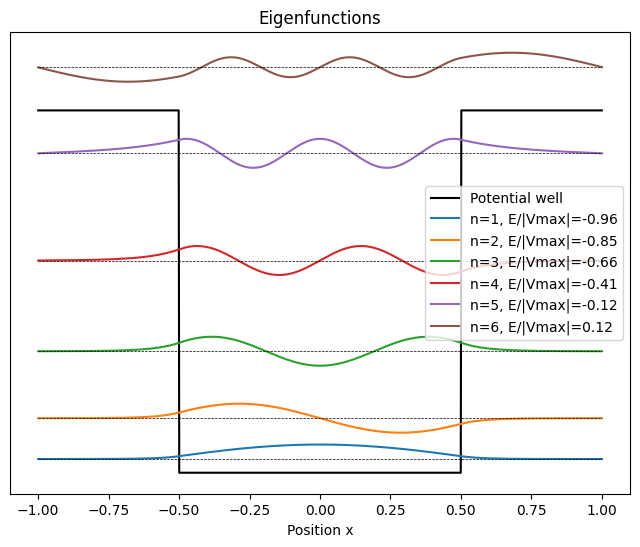

In [17]:
# Constants (several physics quantities set to 1 for simplicity)
hbar  = 1
m     = 1
L     = 1                        # Width of the well
N     = 1000                     # Number of sparial grid points
xmin  = -L                       # Minimum value of x
xmax  =  L                       # Maximum value of x
dx    = (xmax-xmin) / N          # Grid spacing
V0    = -100                     # Well depth
alpha = hbar**2 / (2*m * dx**2)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = single_potential_well(x,V0,L)

# Calculate the Hamiltinian matrix and solve for eigenvalues and eigenvectors
eigenvalues, eigenvectors = solve_tise(V, alpha)

# Plot the first few eigenfunctions
plot_tise_solutions(x, V, eigenvalues, eigenvectors, 6, True)

# Task 1.2: Solving the TISE for a symmetric double square potential well

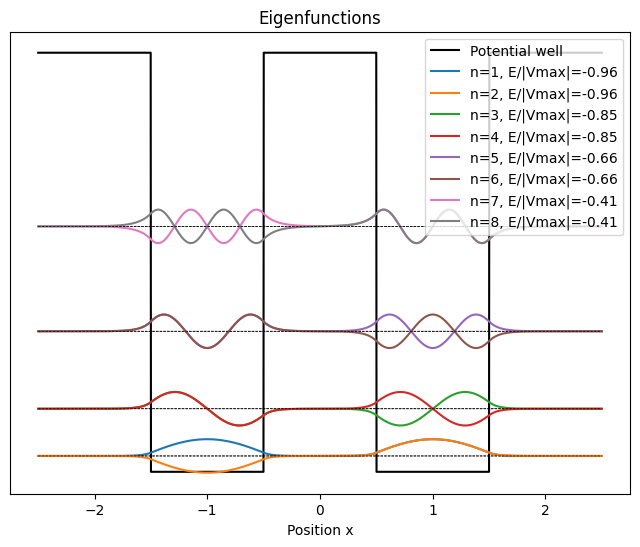

In [18]:
hbar  = 1
m     = 1
N     = 2000                     # Number of sparial grid points
xmin  = -2.5                     # Minimum value of x
xmax  =  2.5                     # Maximum value of x
dx    = (xmax-xmin) / N          # Grid spacing
V0    = [-100, -100]             # Depth of square wells
xc    = [-1, 1]                  # Centres of quare wells
L     = [1, 1]                   # Widths of square wells
alpha = hbar**2 / (2*m * dx**2)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = multiple_potential_wells(x,V0,L,xc)

# Calculate the Hamiltinian matrix and solve for eigenvalues and eigenvectors
eigenvalues, eigenvectors = solve_tise(V, alpha)

# Plot the first few eigenfunctions
plot_tise_solutions(x, V, eigenvalues, eigenvectors, 8, True)

# Task 1.3: Solving the TISE for a smoother symmetric double potential well

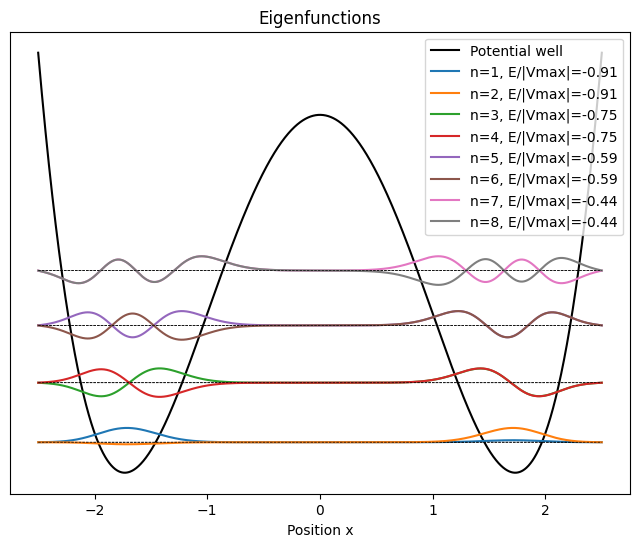

In [19]:
hbar  = 1
m     = 1
N     = 2000                     # Number of sparial grid points
xmin  = -2.5                     # Minimum value of x
xmax  =  2.5                     # Maximum value of x
dx    = (xmax-xmin) / N          # Grid spacing
alpha = hbar**2 / (2*m * dx**2)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = symmetric_double_well_potential(x,10,60)

# Calculate the Hamiltinian matrix and solve for eigenvalues and eigenvectors
eigenvalues, eigenvectors = solve_tise(V, alpha)

# Plot the first few eigenfunctions
plot_tise_solutions(x, V, eigenvalues, eigenvectors, 8, True)

# Task 1.4: Solving the TISE for an asymmetric double square potential well

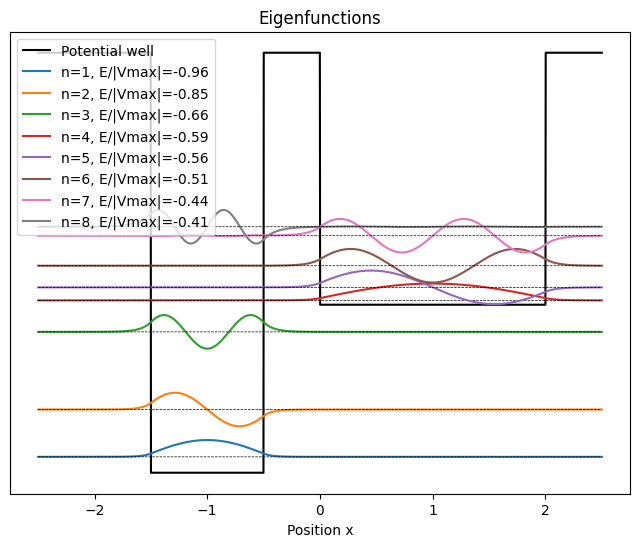

In [20]:
hbar  = 1
m     = 1
N     = 2000                     # Number of sparial grid points
xmin  = -2.5                     # Minimum value of x
xmax  =  2.5                     # Maximum value of x
dx    = (xmax-xmin) / N          # Grid spacing
V0    = [-100, -60]              # Depth of square wells
xc    = [-1, 1]                  # Centres of quare wells
L     = [ 1, 2]                   # Widths of square wells
alpha = hbar**2 / (2*m * dx**2)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = multiple_potential_wells(x,V0,L,xc)

# Calculate the Hamiltinian matrix and solve for eigenvalues and eigenvectors
eigenvalues, eigenvectors = solve_tise(V, alpha)

# Plot the first few eigenfunctions
plot_tise_solutions(x, V, eigenvalues, eigenvectors, 8, True)

# Task 1.5: Solving the TISE for an square potential well followed by a barrier

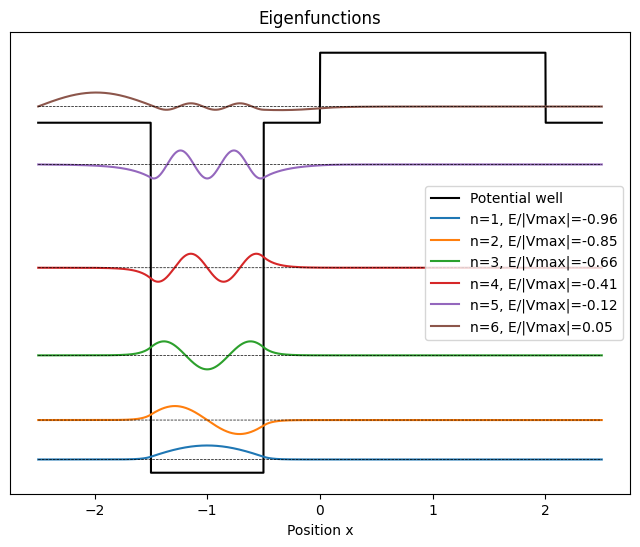

In [21]:
hbar  = 1
m     = 1
N     = 2000                     # Number of sparial grid points
xmin  = -2.5                     # Minimum value of x
xmax  =  2.5                     # Maximum value of x
dx    = (xmax-xmin) / N          # Grid spacing
V0    = [-100, +20]              # Depth of square wells
xc    = [-1, 1]                  # Centres of quare wells
L     = [ 1, 2]                   # Widths of square wells
alpha = hbar**2 / (2*m * dx**2)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = multiple_potential_wells(x,V0,L,xc)

# Calculate the Hamiltinian matrix and solve for eigenvalues and eigenvectors
eigenvalues, eigenvectors = solve_tise(V, alpha)

# Plot the first few eigenfunctions
plot_tise_solutions(x, V, eigenvalues, eigenvectors, 6, True)

# Task 2.1: Check the evolution of a gaussian wavepacket in free space

The wavepacket will disperse, but will remain gaussian. Erroneous wiggles and shoulders in the distribution can easily develop if part of the wavefunction leak outside the simulated space etc. Check that this trivial case is simulated correctly, before studying scattering from a potential barrier.

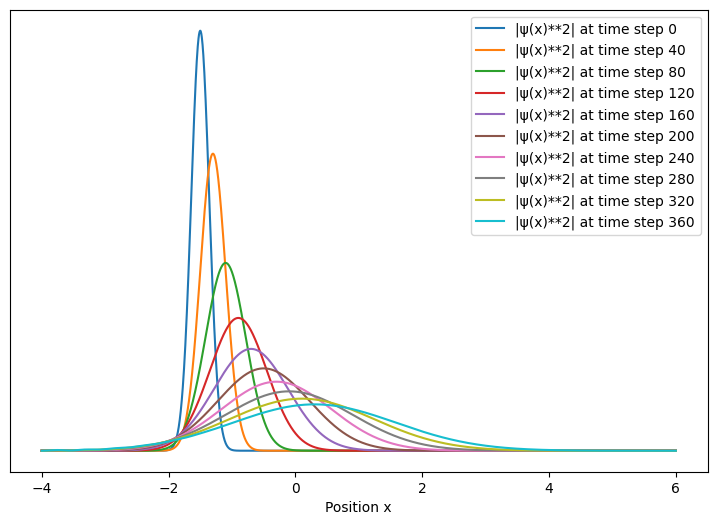

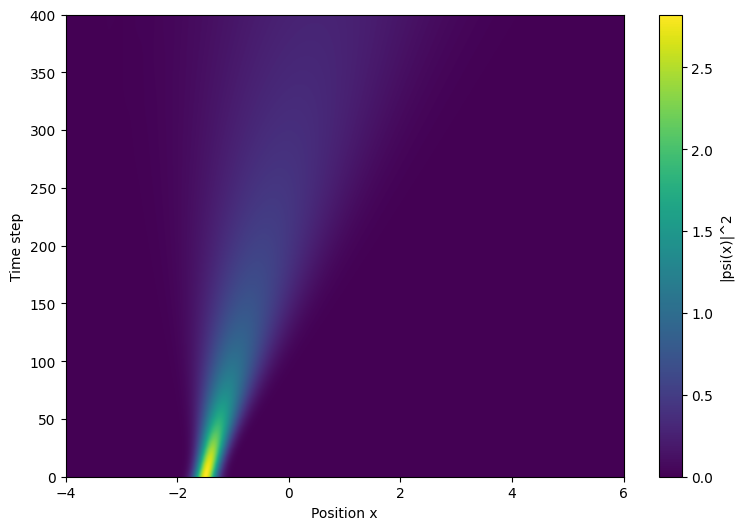

In [22]:
# Constants (several physics quantities set to 1 for simplicity)
hbar  = 1                        #
m     = 1                        #
L     = 1                        # Width of the well
N     = 2500                     # Number of spatial grid points
xmin  = -4*L                     # Minimum value of x
xmax  =  6*L                     # Maximum value of x
dx    = (xmax-xmin) / N          # Spatial grid spacing
Nt    = 400                      # Number of time steps
Nt_p  = 40                       # Visualize time evolved wavefunction every so many steps
dt    = 0.001                    # Time grid spacing
x0    = -1.5*L                   # Initial wavepacket position
k0    = 5.0                      # Initial wavepacket momentum
sigma = L/5                      # Initial Wave packet width
alpha = hbar**2 / (2*m * dx**2) 
beta  = 1j * dt/(2*hbar)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Free space: Potential is zero everywhere
V = np.zeros(N)

# Create the initial wave-packet (Gaussian centered at x0 with momentum k0) and plot it
psi0 = gaussian_wavepacket(x,x0,sigma,k0)
# plot_wavefunction(psi0,label="Initial wavepacket")

# Solve the time dependent Schrodinger equation and get the evolved wavefunction at each time step
psi_t = solve_tdse(V, alpha, beta, psi0, dx, Nt)

# Plots time evolution of wavefunction, and transmission/reflection coefficients
plot_tdse_solutions(x, V, psi_t, Nt, Nt_p)

# Task 2.2: Solve the TDSE for a gaussian wavepacket travelling towards a potential barrier, and study the wave transmission and reflection.

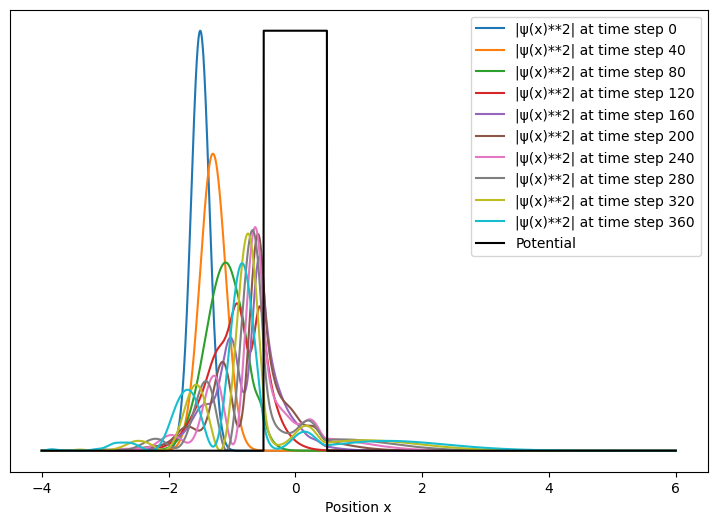

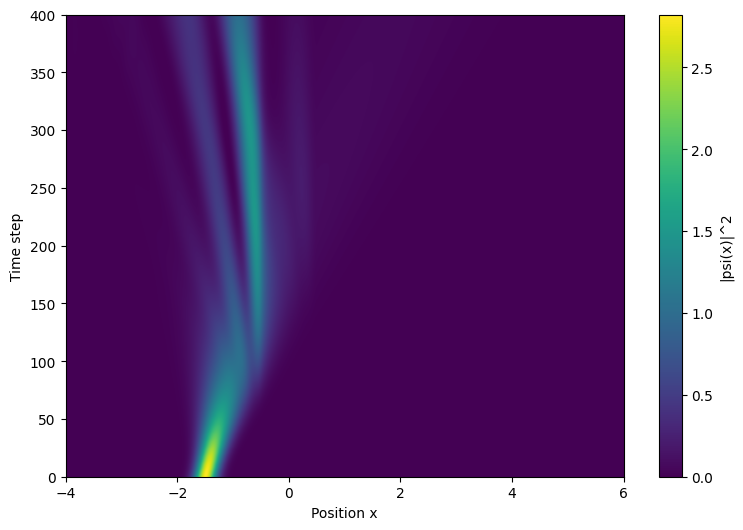

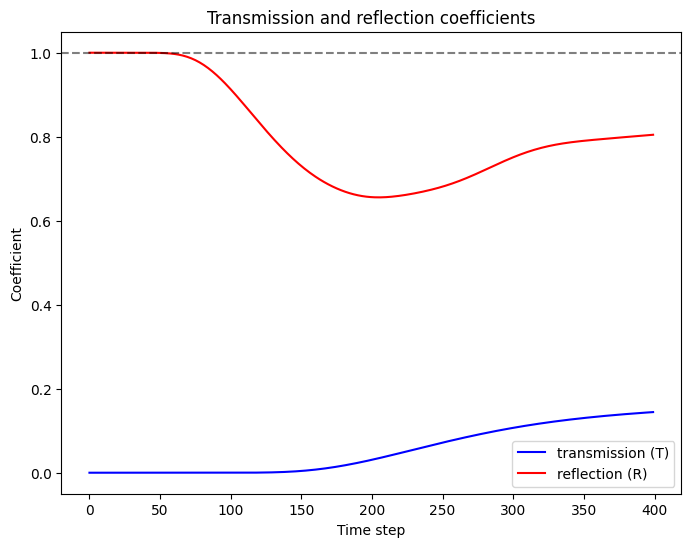

In [24]:
# Constants (several physics quantities set to 1 for simplicity)
hbar  = 1                        #
m     = 1                        #
L     = 1                        # Width of the well
N     = 2500                     # Number of spatial grid points
xmin  = -4*L                     # Minimum value of x
xmax  =  6*L                     # Maximum value of x
dx    = (xmax-xmin) / N          # Spatial grid spacing
V0    = 30                       # Barrier height
Nt    = 400                      # Number of time steps
Nt_p  = 40                       # Visualize time evolved wavefunction every so many steps
dt    = 0.001                    # Time grid spacing
x0    = -1.5*L                   # Initial wavepacket position
k0    = 5.0                      # Initial wavepacket momentum
sigma = L/5                      # Initial Wave packet width
alpha = hbar**2 / (2*m * dx**2) 
beta  = 1j * dt/(2*hbar)

# Create 1D space grid
x = np.linspace(xmin, xmax, N)

# Compute the potential at each grid point
V = single_potential_well(x,V0,L)

# Create the initial wave-packet (Gaussian centered at x0 with momentum k0) and plot it
psi0 = gaussian_wavepacket(x,x0,sigma,k0)
# plot_wavefunction(psi0,label="Initial wavepacket")

# Solve the time dependent Schrodinger equation and get the evolved wavefunction at each time step
psi_t = solve_tdse(V, alpha, beta, psi0, dx, Nt)

# Plots time evolution of wavefunction, and transmission/reflection coefficients
plot_tdse_solutions(x, V, psi_t, Nt, Nt_p)
plot_transmission_and_reflection_coefficients(psi_t, x, transmission_xrange=[L/2,xmax], reflection_xrange=[xmin,-L/2])

**References and suggested reading:**

\[1\] W. van Dijk, On numerical solutions of the time-dependent Schrodinger equation, [Am.J.Phys. 91 (2023) 10, 826](https://inspirehep.net/literature/2665340)

\[2\] W. van Dijk and F. M. Toyama, Accurate numerical solutions of the time-dependent Schrodinger equation, [Phys. Rev. E 75, 036707](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.75.036707)
